In [3]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [4]:
def synthetic_data(w, b, num_examples): 
    """生成y=Xw+b+噪声"""
    #均值为0，方差为1，形状为1000*2的张量 
    X = torch.normal(0, 1, (num_examples, len(w)))
    #矩阵乘法，1000*2 X 2*1
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    #-1参数自动计算维数
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [5]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([ 1.7261, -0.2564]) 
label: tensor([8.5213])


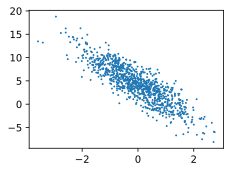

In [6]:
d2l.set_figsize()
#detach().numpy()将张量从计算图中分离出来，使其不参与梯度计算
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1);

In [7]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    #创建一个索引链表
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序，shuffle 打乱顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        #返回一个批量的数据
        yield features[batch_indices], labels[batch_indices]

In [8]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.4503,  0.5464],
        [ 0.1122,  2.2084],
        [-0.7518,  1.5245],
        [ 1.0168, -0.8119],
        [ 0.7620,  0.4668],
        [ 0.2493,  0.2035],
        [-1.6424,  0.6553],
        [ 0.6735,  0.0105],
        [-1.1849, -1.4385],
        [-0.3786, -1.5060]]) 
 tensor([[ 3.2385],
        [-3.0888],
        [-2.4776],
        [ 9.0149],
        [ 4.1423],
        [ 4.0208],
        [-1.3161],
        [ 5.4989],
        [ 6.6978],
        [ 8.5666]])


In [9]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [10]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [11]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [12]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    #更新参数时不需要计算梯度
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [13]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.028612
epoch 2, loss 0.000094
epoch 3, loss 0.000048


In [14]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0005, -0.0005], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0005], grad_fn=<RsubBackward1>)
